In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import re

# Data Cleaning

In [2]:
%store -r df_nation
%store -r df_series_groups

In [3]:
#df_nation grouped by level_frequency 
# 0 -> 26 (proper_names) , 27 (marginal_words), 28 (compounds), 29 (acronyms)
# (5-25) -> levels from 5 to 15
#df_nation grouped by levels_coverage
# 15 -> (15: list between 15 and 25)

# df_nation.groupby('levels').count()
# df_nation.groupby('levels_frequency').count()
df_nation.groupby('levels_coverage').count() 
df_nation.sort_values('all_forms')

,base_forms,all_forms,levels,levels_frequency,levels_coverage
56173,a,a,1,1,1
1149,a1,a1,26,0,26
1150,a11,a11,26,0,26
1151,a168,a168,26,0,26
1152,a19,a19,26,0,26
...,...,...,...,...,...
30895,emigre,émigrés,12,5-25,12
69601,esprit,ésprit,16,5-25,15
89976,etoile,étoile,20,5-25,15
52372,etudes,étude,15,5-25,15


In [4]:
# downloading series script
df_got = pickle.load(open('df_got', 'rb'))
df_got.reset_index(drop=True, inplace=True)

In [5]:
#this data has cleaned transcripts but in a 'not' good way e.g. "You're" shows like 'youre' instead of 'you are'
df_got_kaggle = pd.read_csv('got_scripts_breakdown.csv', delimiter=';')
# s1e3 = ' '.join(df_got_kaggle[df_got_kaggle['Episode']=='lord snow']['Sentence'].values)
# df_got.loc[df_got['season_episode_names']=='S1E3: Lord Snow', 'transcripts'] = s1e3

### Cleaning non-English letters

In [8]:
#'ν' --> 'v'
df_got['transcripts'] = df_got['transcripts'].apply(lambda x:re.sub('ν', 'v', x))
# 'l'--> i e.g. lmp (imposible) -> There's a problem coming from the source of the transcripts itself
# all i in upper case are treated as l (l in lower case) Fortunately most of them are pronouns like 'I' , but some words starting with 'i' in upper case are lost (small %)

In [9]:
df_got['raw_tokens'] = df_got['transcripts'].apply(lambda x:len(x.split()))

In [10]:
#the difference between tokens_raw and tokens shouldn't be so much since only speaker's name,
#words within parentheses and squarebrackets were removed
print('Min Raw: ' + str(df_got['raw_tokens'].min()))
# #and only contractions were added "'n" --> 'not'
print('Max Raw: ' + str(df_got['raw_tokens'].max()))

Min Raw: 2391
Max Raw: 6254


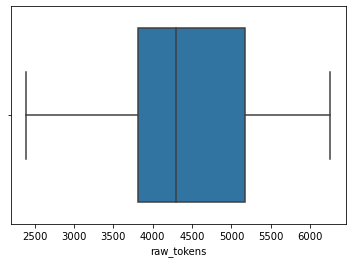

In [11]:
sns.boxplot(x=df_got['raw_tokens'])

In [12]:
# cleaning transcripts
from cleaning import clean_transcripts

round1 = lambda x: clean_transcripts(x)
df_got['transcripts'] = df_got['transcripts'].apply(round1)

In [13]:
# df_series_clean_except_transcripts.groupby('series_titles').count()
df_got = df_got.assign(tokens=df_got['transcripts'].apply(lambda x:len(x.split())))

In [14]:
#the difference between tokens_raw and tokens shouldn't be so much since only speaker's name,
#words within parentheses and squarebrackets were removed
print('Min Raw: ' + str(df_got['raw_tokens'].min()) + ', Min Clean: '+ str(df_got['tokens'].min()))
# #and only contractions were added "'n" --> 'not'
print('Max Raw: ' + str(df_got['raw_tokens'].max()) + ', Max Clean: '+ str(df_got['tokens'].max()))

Min Raw: 2391, Min Clean: 2391
Max Raw: 6254, Max Clean: 6254


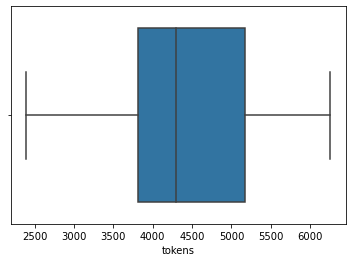

In [15]:
sns.boxplot(x=df_got['tokens'])

### Episodes with less dialogues (less words to worry about)

In [16]:
df_got.sort_values('raw_tokens')[:5]

,transcripts,titles,years,seasons,season_episodes,season_episode_names,raw_tokens,tokens
1,you need to drink child and eat ls not there ...,game of thrones,2011,1,2,S1E2: The Kingsroad,2391,2391
50,it s coming from the courtyard it s the lord c...,game of thrones,2011,6,1,S6E1: The Red Woman,2473,2473
69,oi mind out move look on the west wa...,game of thrones,2011,8,3,S8E3: The Long Night,2736,2736
12,robb tomorrow you will ride south to the storm...,game of thrones,2011,2,3,S2E3: What Is Dead May Never Die,2833,2833
58,uploaded by somnath yadav follow on instagram ...,game of thrones,2011,6,9,S6E9: Battle of the Bastards,2891,2891


# Exploratory Data Analysis

### Document-Term Matrix¶

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import scipy.sparse
cv = CountVectorizer()#only misleading words excluded for the analysis
cv_matrix = cv.fit_transform(df_got['transcripts'])
df_dtm = pd.DataFrame.sparse.from_spmatrix(cv_matrix, index=df_got.index,
                                           columns=cv.get_feature_names())

In [18]:
df_dtm = df_dtm.T

# Formula

In [19]:
def get_frames(indices, dtm, thousand_level=None): #, thousand_level ['4'], ['5-14']
    """1. The df_dtm gives the number of times a word (all_forms) shows up in an episode/movie
       2. Then its joined to get the level and base_forms of each word
       3. The final df has the words counted for each episode so it can be seen base_forms repetition in the final df"""
    frames = []
    for index in indices:
        df_count_words = dtm[[index]].loc[dtm[index]!=0]
        df_count_words = df_count_words.reset_index()
        df_count_words.rename(columns={"index": "all_forms", index: "count"}, inplace=True)

        df_count_words_level = pd.merge(df_count_words, df_nation[['base_forms', 'all_forms',
                                'levels_frequency', 'levels', 'levels_coverage']], how='left', on='all_forms', indicator=True)
        df_count_words_level.loc[df_count_words_level['_merge']=='left_only', 'levels_coverage'] = 100
        if thousand_level is not None: #only consider words in specific levels
            df_count_words_level = df_count_words_level[df_count_words_level['levels_frequency'].isin(thousand_level)]
        frames.append(df_count_words_level)
    df_count_words_level = pd.concat(frames)
    return df_count_words_level

In [20]:
def get_coverage(indices, df_dtm):
    frames = []
    for episode_index in indices:
        df_coverage_episode = get_frames([episode_index], df_dtm) ##
        df_coverage_episode = df_coverage_episode[['count' ,'levels_coverage']].groupby('levels_coverage').sum()
        df_coverage_episode.drop([28, 29], axis=0, inplace=True, errors='ignore')
        df_coverage_episode['%'] = 100 * (round(df_coverage_episode['count']/
                                            df_coverage_episode['count'].sum(), 4))
        df_coverage_episode = df_coverage_episode.reset_index()
        condition = [(df_coverage_episode['levels_coverage']<=4),
            (df_coverage_episode['levels_coverage']>=5) & (df_coverage_episode['levels_coverage']<=15),
                    (df_coverage_episode['levels_coverage']>=26)] #15 includes list from 15 to 25
        values = [df_coverage_episode['levels_coverage'], 5, df_coverage_episode['levels_coverage']]
        df_coverage_episode['lvl'] = np.select(condition, values)
        df_coverage_episode = df_coverage_episode.groupby('lvl').sum()
        df_coverage_episode['cumulative'] = df_coverage_episode['%'].cumsum()
        if len(indices)==1:   
            df_coverage_episode = df_coverage_episode[['count', '%']].T.reset_index(drop=True)
        elif len(indices)>1:
            df_coverage_episode = df_coverage_episode[['%']].T.reset_index(drop=True)
            df_coverage_episode['index'] = episode_index
        frames.append(df_coverage_episode)
    return frames

### Vocabulary coverage of a random episode

In [21]:
index = 20 #episode number is different from index!!!
series_name = 'Game of Thrones'
df_random_episode = get_coverage([index], df_dtm)[0]
df_random_episode.rename(columns={26:'Character names', 27:'Interjections', 
                                  100:series_name+" words"}, inplace=True)
df_random_episode.T.rename(columns={0:'count', 1:'%'})

,count,%
lvl,,
1.0,3501.0,85.91
2.0,204.0,5.01
3.0,47.0,1.15
4.0,52.0,1.28
5.0,124.0,3.05
Character names,33.0,0.81
Interjections,7.0,0.17
Game of Thrones words,107.0,2.63


### Unique words in the TV show

In [22]:
df_words_series = get_frames(df_got.index.values, df_dtm)
df_words_series = df_words_series[['all_forms', 'count', 'levels_coverage']]
df_words_series = df_words_series[df_words_series['levels_coverage']==100]
df_words_series

#check .groupby sparse(int64)
list_words = list(df_words_series['all_forms'])
list_count = list(df_words_series['count'])

In [23]:
df_test = get_frames(df_got.index.values, df_dtm)
df_test = df_test[['all_forms', 'count', 'levels_coverage']]
df_test = df_test[df_test['levels_coverage']==100]
df_test

,all_forms,count,levels_coverage
6,aegon,1,100.0
22,alys,2,100.0
27,andals,1,100.0
37,archmaester,2,100.0
61,baelish,2,100.0
...,...,...,...
651,tyrion,3,100.0
652,tywin,1,100.0
656,underst,1,100.0
666,varys,2,100.0


### Wordcloud

In [24]:
#top50
character_name = pd.read_csv('got_scripts_breakdown.csv', delimiter=';').groupby(
    'Name').count().sort_values('Column1', ascending=False)[:100].index.values
character_name = list(character_name)
clean_words = ['youre', 'dont', 'didnt', 'youll', 'youve', 'shes', 'doesnt']
character_name.extend(clean_words)

df_words_series = pd.DataFrame({'words':list_words, 'count':list_count})
df_words_series = df_words_series.groupby('words', as_index=False).sum().sort_values('count', ascending=False)

# words only found in the series excluding character names
df_words_series = df_words_series[~df_words_series['words'].isin(character_name)]

In [25]:
df_words_series['words'] = df_words_series['words'].apply(lambda x:x+' ')
df_words_series['text'] = df_words_series['words']*df_words_series['count']
got_words = ''.join(df_words_series['text'])

In [26]:
import stylecloud
from wordcloud import STOPWORDS

stylecloud.gen_stylecloud(got_words, palette="cmocean.sequential.Matter_16", 
                          background_color="white", icon_name= "fas fa-dragon",
                          colors=['#900C3F', '#900C3F', '#900C3F'], collocations=False)

### Lines per character

In [27]:
df_top_lines = df_got_kaggle.groupby(['Name', 'Season'], as_index=False)[['Sentence']].count().sort_values('Sentence', ascending=False)
df_top_lines = df_top_lines[df_top_lines['Name'].isin(character_name[:10])]

df_top_lines = pd.pivot_table(df_top_lines, values='Sentence', index='Season', columns='Name', aggfunc=np.sum)
df_top_lines = df_top_lines.fillna(0)
for i in df_top_lines.reset_index().values:
    print(str(i[0])+', '+str(i[1])+', '+str(i[2])+', '+str(i[3])+', '+str(i[4])+
          ', '+str(i[5])+', '+str(i[6])+', '+str(i[7])+', '+str(i[8])+', '+str(i[9])+', '+str(i[10]))

Season 1, 103.0, 118.0, 127.0, 0.0, 82.0, 139.0, 111.0, 52.0, 100.0, 212.0
Season 2, 129.0, 177.0, 136.0, 95.0, 71.0, 101.0, 79.0, 49.0, 80.0, 345.0
Season 3, 109.0, 102.0, 117.0, 96.0, 132.0, 90.0, 42.0, 73.0, 96.0, 242.0
Season 4, 101.0, 160.0, 102.0, 47.0, 183.0, 138.0, 72.0, 102.0, 99.0, 225.0
Season 5, 79.0, 188.0, 128.0, 52.0, 104.0, 162.0, 91.0, 99.0, 95.0, 186.0
Season 6, 64.0, 84.0, 89.0, 99.0, 118.0, 111.0, 34.0, 50.0, 113.0, 160.0
Season 7, 105.0, 155.0, 162.0, 79.0, 152.0, 213.0, 46.0, 67.0, 136.0, 167.0


### Vocabulary coverage of the average GoT episode - Should I watch Friends, The Simpsons or GoT?

In [28]:
frames = get_coverage(df_got.index.values, df_dtm)

In [29]:
pd.concat(frames, axis=0, ignore_index=True)[[1, 2, 3, 4, 5, 26, 27, 100]].mean()

lvl
1.0      86.023562
2.0       4.726712
3.0       1.273562
4.0       1.228630
5.0       2.417397
26.0      0.844658
27.0      0.458493
100.0     3.030274
dtype: float64

### Vocabulary coverage in all episodes

In [30]:
df_statistics = pd.concat(frames, axis=0, ignore_index=True)[['index', 1, 2, 3, 4, 5, 26, 27, 100]]
#assume you know interjections, character names and words created in the tv series
df_statistics['Lvl 1'] = df_statistics[1] + df_statistics[26] + df_statistics[27] + df_statistics[100]
df_statistics['Lvl 1+2'] = df_statistics['Lvl 1'] + df_statistics[2]
df_statistics['Lvl 1+2+3'] = df_statistics['Lvl 1+2'] + df_statistics[3]
df_statistics['Lvl 1+2+3+4'] = df_statistics['Lvl 1+2+3'] + df_statistics[4]
df_statistics = pd.concat((df_statistics.set_index('index'), df_got[['season_episode_names', 'seasons']]), axis=1)
df_statistics

,1.0,2.0,3.0,4.0,5.0,26.0,27.0,100.0,Lvl 1,Lvl 1+2,Lvl 1+2+3,Lvl 1+2+3+4,season_episode_names,seasons
0,86.13,5.19,1.55,1.23,2.14,0.63,0.45,2.68,89.89,95.08,96.63,97.86,S1E1: Winter Is Coming,1
1,86.88,4.12,0.90,1.81,2.69,0.95,0.54,2.13,90.50,94.62,95.52,97.33,S1E2: The Kingsroad,1
2,83.48,5.18,1.13,1.67,2.82,0.68,0.24,4.81,89.21,94.39,95.52,97.19,S1E3: Lord Snow,1
3,84.97,4.20,1.19,1.21,2.95,1.00,0.60,3.89,90.46,94.66,95.85,97.06,"S1E4: Cripples, Bastards, and Broken Things",1
4,85.76,3.61,1.18,1.17,2.95,0.97,0.80,3.55,91.08,94.69,95.87,97.04,S1E5: The Wolf and the Lion,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,89.52,3.78,1.01,0.77,1.93,0.71,0.39,1.87,92.49,96.27,97.28,98.05,S8E2: A Knight of the Seven Kingdoms,8
69,88.02,4.37,1.74,0.54,1.94,0.85,0.54,2.01,91.42,95.79,97.53,98.07,S8E3: The Long Night,8
70,88.15,4.55,1.06,0.91,1.61,0.59,0.63,2.48,91.85,96.40,97.46,98.37,S8E4: The Last of the Starks,8
71,89.02,5.26,1.18,0.90,1.15,0.73,0.15,1.63,91.53,96.79,97.97,98.87,S8E5: The Bells,8


### Top 10 GoT episodes (easies vocabulary)

In [31]:
for i in df_statistics.sort_values(['Lvl 1'], ascending=False)[:10].values:
    print(i[12])

S6E3: Oathbreaker
S7E6: Beyond the Wall
S8E2: A Knight of the Seven Kingdoms
S2E4: Garden of Bones
S2E10: Valar Morghulis
S8E4: The Last of the Starks
S3E6: The Climb
S8E5: The Bells
S2E1: The North Remembers
S3E2: Dark Wings, Dark Words


### ScatterPlot

In [32]:
#preparing data
df_1 = df_statistics[['Lvl 1', 'season_episode_names']]
df_1 = df_1.assign(label = 'Lvl 1')
df_1.rename(columns={'Lvl 1':'lvl'}, inplace=True)
df_2 = df_statistics[['Lvl 1+2', 'season_episode_names']]
df_2 = df_2.assign(label = 'Lvl 1+2')
df_2.rename(columns={'Lvl 1+2':'lvl'}, inplace=True)
df_3 = df_statistics[['Lvl 1+2+3', 'season_episode_names']]
df_3 = df_3.assign(label = 'Lvl 1+2+3')
df_3.rename(columns={'Lvl 1+2+3':'lvl'}, inplace=True)
df_4 = df_statistics[['Lvl 1+2+3+4', 'season_episode_names']]
df_4 = df_4.assign(label = 'Lvl 1+2+3+4')
df_4.rename(columns={'Lvl 1+2+3+4':'lvl'}, inplace=True)
df_dot = pd.concat([df_1, df_2, df_3, df_4])
df_dot['lvl'] = df_dot['lvl'].apply(lambda x:round(x,1))

In [33]:
episode_count = []

for index, percentage in enumerate(df_dot['lvl']):
    subset = df_dot.iloc[:index+1]    # Create subset starting at the beginning of dataset until the episode
    count = len(subset[subset['lvl'] == percentage])   # Count all episode with same % in this subset
    episode_count.append(count)
    
df_dot['count'] = episode_count

In [34]:
df_dot['season_episode_names'] = df_dot['season_episode_names'].apply(lambda x:re.sub(',', '', x))

In [48]:
# data for DataWrapper
# for i in df_dot.values:
#     print(i[1] + ' , ' + i[2] + ' , ' + str(i[3]) + ' , ' + str(i[0]))

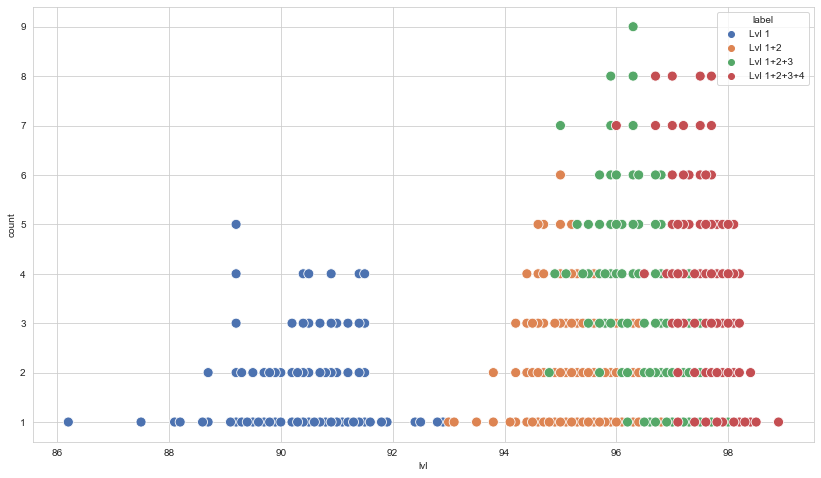

In [50]:
#Static plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.scatterplot(x='lvl', y='count', data=df_dot,
             hue='label', s=100, ax=ax, palette="deep")

# Interactive plot
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode()

# fig = go.Figure()
# for genre, df_genre in df_dot.groupby('label'):
#     fig.add_scatter(x=df_genre["lvl"], y=df_genre['count'], text=df_genre['season_episode_names'],
#     name=genre, mode='markers')
# iplot(fig)

### What hard words are they saying across all GoT episodes?

In [37]:
frames_2 = []
for episode_index in df_got.index.values:
    df_vocabulary_episode = get_frames([episode_index], df_dtm, ['3', '4', '5-25'])
    df_vocabulary_episode['index'] = episode_index
    frames_2.append(df_vocabulary_episode)

In [47]:
df_got_lvl[df_got_lvl['season_episode_names'].str.contains('S5E6')]
df_got_lvl

,all_forms,count,base_forms,levels_frequency,season_episode_names
0,ale,1,ale,5-25,S1E1: Winter Is Coming
1,allies,7,ally,3,S1E1: Winter Is Coming
2,alongside,1,alongside,3,S1E1: Winter Is Coming
3,ancestral,1,ancestor,4,S1E1: Winter Is Coming
4,arbor,1,arbour,5-25,S1E1: Winter Is Coming
...,...,...,...,...,...
10378,tyrant,2,tyrant,5-25,S8E6: The Iron Throne
10379,unsullied,5,sully,5-25,S8E6: The Iron Throne
10380,vanity,1,vanity,5-25,S8E6: The Iron Throne
10381,veteran,1,veteran,3,S8E6: The Iron Throne


In [44]:
df_got_lvl = pd.concat(frames_2)
df_got_lvl = pd.merge(df_got_lvl, df_got[['season_episode_names']].reset_index(), on='index')
df_got_lvl = df_got_lvl[['all_forms', 'count', 'base_forms', 'levels_frequency', 'season_episode_names']]
df_got_lvl['season_episode_names'] = df_got_lvl['season_episode_names'].apply(lambda x:re.sub(',', '', x))
# df_got_lvl[df_got_lvl['levels_coverage']>=15]

In [49]:
#data for Datawrapper
# for i in df_got_lvl.values:
#     print(str(i[0])+', '+str(i[1])+', '+str(i[2])+', '+str(i[3])+', '+str(i[4]))